# VANESSA ATALANATA — YEARS OF OUTBREAKS

Let's focus on single years of high abundance.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
from IPython.display import display
import re
from matplotlib import cm, colors

In [2]:
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# get hex color codes of Dark2 matplotlib colormap
cmap = cm.get_cmap('Dark2', 8)
hex = []
for i in range(cmap.N):
    rgba = cmap(i)
    # convert rgb(a) to hex
    hex.append(colors.rgb2hex(rgba))

In [3]:
# data import
count_daily = pd.read_csv('../../data/all_species_count_daily.csv',
                          parse_dates=['date'])

count_by_trap = pd.read_csv('../../data/all_species_count_by_trap.csv',
                            parse_dates=['date'])

In [4]:
# focussing on traps L-4 & L-5 exclusively!
count_by_trap = count_by_trap[count_by_trap.trap.str.contains('L-(4|5)')].reset_index(drop=True)

/tmp/ipykernel_16682/566974646.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  count_by_trap = count_by_trap[count_by_trap.trap.str.contains('L-(4|5)')].reset_index(drop=True)


### SEASONAL PATTERN

In [5]:
# focus on years 1998 to 2020
count_by_trap_short = count_by_trap[count_by_trap.year >= 1998].reset_index(drop=True)

# combine counts of same cardinal direction for each day
count_by_dir_short = (
    count_by_trap_short
    .groupby(['species', 'year', 'month', 'day', 'date', 'trap_dir'],
             as_index=False)
    ['count'].sum(min_count=1)
)

# add number of week as new column
count_by_dir_short['week'] = count_by_dir_short['date'].dt.isocalendar().week

display(count_by_dir_short)

,species,year,month,day,date,trap_dir,count,week
0,Aglais urticae,1998,4,1,1998-04-01,north,NaN,14
1,Aglais urticae,1998,4,1,1998-04-01,south,NaN,14
2,Aglais urticae,1998,4,2,1998-04-02,north,NaN,14
3,Aglais urticae,1998,4,2,1998-04-02,south,NaN,14
4,Aglais urticae,1998,4,3,1998-04-03,north,NaN,14
...,...,...,...,...,...,...,...,...
148345,Vanessa cardui,2020,10,30,2020-10-30,south,NaN,44
148346,Vanessa cardui,2020,10,31,2020-10-31,north,NaN,44
148347,Vanessa cardui,2020,10,31,2020-10-31,south,NaN,44
148348,Vanessa cardui,2020,11,1,2020-11-01,north,NaN,44


In [39]:
from datetime import date

yr = 2020
# https://stackoverflow.com/questions/17087314/get-date-from-week-number
def week_to_date(weeknumber):
        new_date = date.strptime(
                str(yr)+'-'+str(weeknumber)+'-1',
                '%G-%V-%u'
        )
        return new_date

type(week_to_date(14))

AttributeError: type object 'datetime.date' has no attribute 'strptime'

In [41]:
from datetime import date

yr = 2020
# https://stackoverflow.com/questions/17087314/get-date-from-week-number
def week_to_date(weeknumber):
        new_date = date.fromisocalendar(yr, weeknumber, 1)
        return new_date

week_to_date(14)

datetime.date(2020, 3, 30)

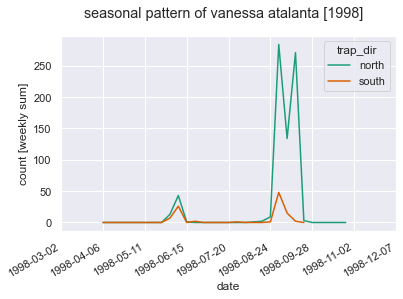

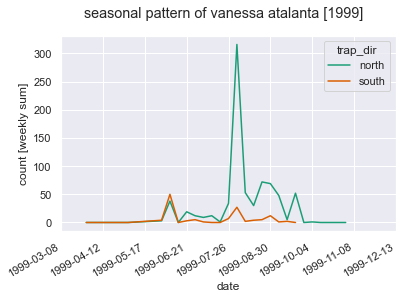

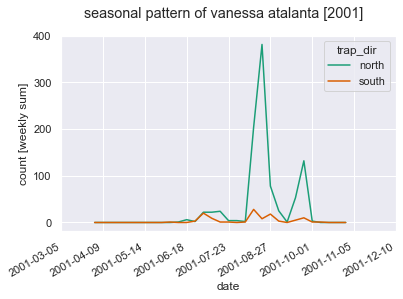

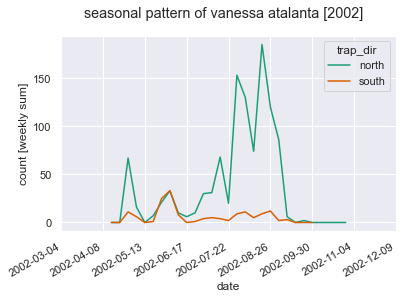

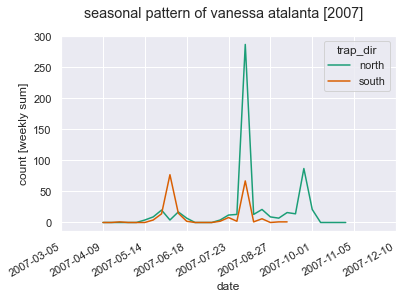

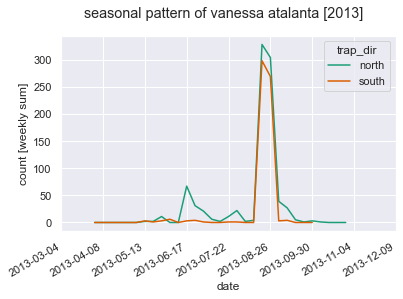

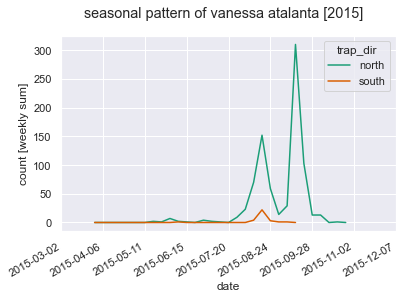

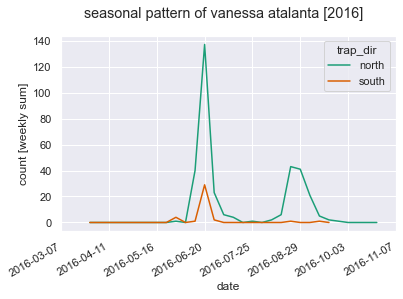

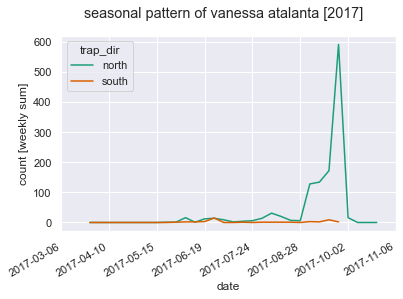

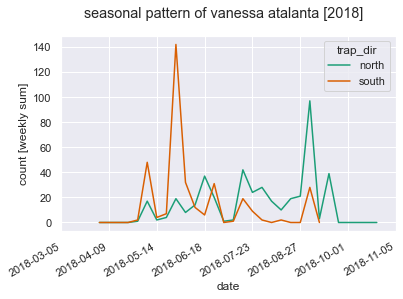

In [60]:
import matplotlib.dates as mdates

# plotting seasonal signal
def plot_seasonal(s, yr):
    data = (
        count_by_dir_short[
            (count_by_dir_short.species == s)
            & (count_by_dir_short.year == yr)
        ]
        .groupby(['week', 'trap_dir'], as_index=False)
        ['count'].sum(min_count=1)
    )

    fig, ax = plt.subplots()
    sns.lineplot(data=data, x='week', y='count', hue='trap_dir', ax=ax)

    # convert xlabels to dates -------------------------------------------------
    # https://stackoverflow.com/questions/17087314/get-date-from-week-number
    def week_to_date(weeknumber):
        return date.fromisocalendar(yr, int(weeknumber), 1)

    ticks = plt.xticks()[0]
    dates = [week_to_date(x) for x in ticks]
    plt.xticks(ticks, dates)

    fig.autofmt_xdate()
    ax.grid()
    # --------------------------------------------------------------------------
    
    ax.set_ylabel(f'count [weekly sum]')
    ax.set_xlabel('date')
    fig.suptitle(f'seasonal pattern of {s.lower()} [{yr}]')

# for years of outbreaks (spring & autumn!)
yrs_outbreak_va = [1998, 1999, 2001, 2002, 2007, 2013, 2015, 2016, 2017, 2018]
for yr in yrs_outbreak_va:
    plot_seasonal('Vanessa atalanta', yr)

### PROPORTION OF CARDINAL DIRECTIONS

In [7]:
# compute proportion of both cardinal directions in monthly count
count_per_monthly = (
    count_by_dir_short
    .groupby(['species', 'year', 'month', 'trap_dir'], as_index=False)
    ['count'].sum(min_count=1)
)
# total count per month (both traps combined)
arr_count_weekly = (
    count_by_dir_short
    .groupby(['species', 'year', 'month'])
    ['count'].sum(min_count=1).values
)
arr_count_weekly = np.repeat(arr_count_weekly, repeats=2)

count_per_monthly['count_per'] = count_per_monthly['count'] / arr_count_weekly * 100
count_per_monthly['count_per'] = count_per_monthly['count_per'].fillna(0)

display(count_per_monthly)

,species,year,month,trap_dir,count,count_per
0,Aglais urticae,1998,4,north,0.0,0.0
1,Aglais urticae,1998,4,south,0.0,0.0
2,Aglais urticae,1998,5,north,0.0,0.0
3,Aglais urticae,1998,5,south,0.0,0.0
4,Aglais urticae,1998,6,north,0.0,0.0
...,...,...,...,...,...,...
5515,Vanessa cardui,2020,9,south,1.0,100.0
5516,Vanessa cardui,2020,10,north,0.0,0.0
5517,Vanessa cardui,2020,10,south,NaN,0.0
5518,Vanessa cardui,2020,11,north,NaN,0.0


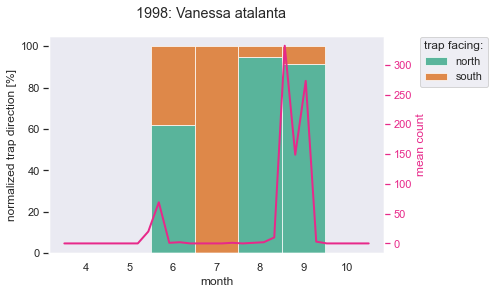

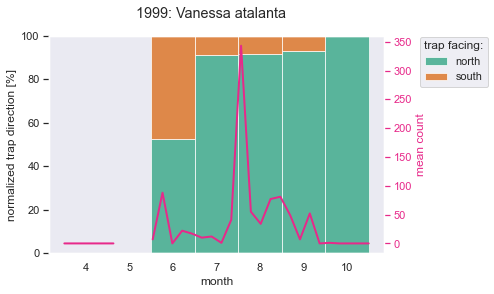

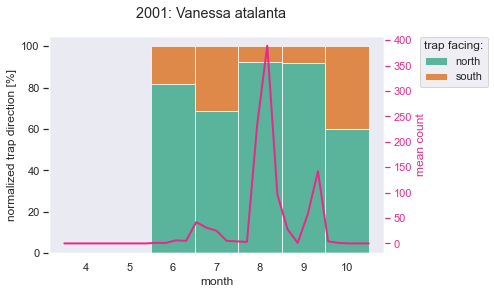

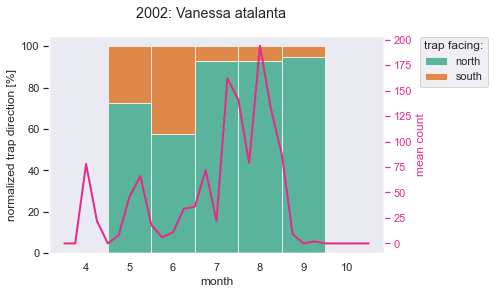

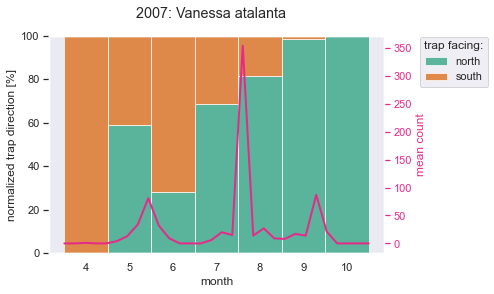

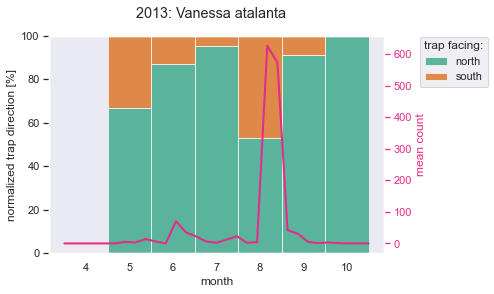

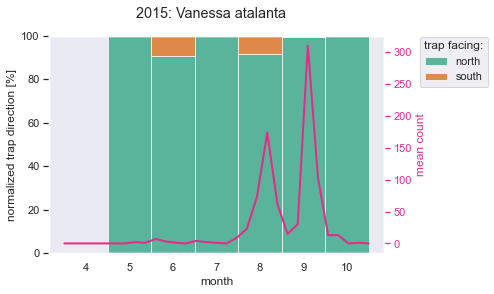

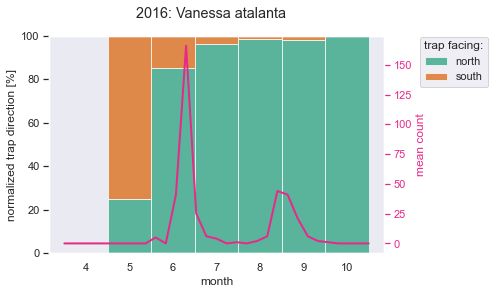

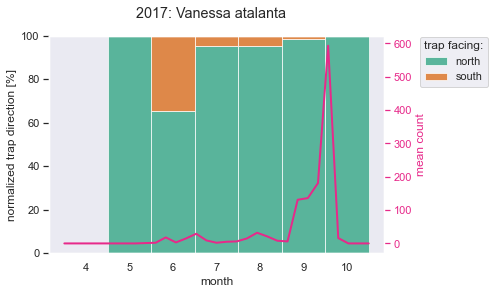

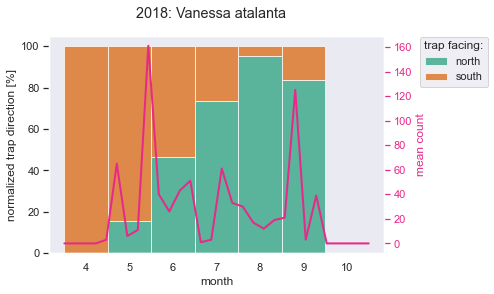

In [8]:
# plotting
sns.set_theme(
    style="dark",
    color_codes=True,
    palette='Dark2',
)

def plot_seasonal_per(s, yr):
    bars = (
        count_per_monthly[
            (count_per_monthly.species == s)
            & (count_per_monthly.year == yr)
            & (count_per_monthly.month < 11) # exclude november
        ]
    )
    line = (
        count_by_dir_short[
            (count_by_dir_short.species == s)
            & (count_by_dir_short.year == yr)
        ]
        .groupby(['week'], as_index=False)
        ['count'].sum(min_count=1)
    )
    months = np.arange(4, 11)

    fig, ax = plt.subplots()
    ax.bar(
        months,
        bars[bars.trap_dir == 'north'].count_per.values,
        label='north', 
        width=1, alpha=0.7
    )
    ax.bar(
        months,
        bars[bars.trap_dir == 'south'].count_per.values,
        label='south',
        bottom=bars[bars.trap_dir == 'north'].count_per.values,
        width=1, alpha=0.7   
    )
    ax.set_ylabel('normalized trap direction [%]')
    ax.set_xlabel('month')
 
    secax = ax.twinx()
    secax.tick_params(axis='y', colors=hex[3])
    secax.set_ylabel('mean count', color=hex[3])
    ssecax = secax.twiny()
    ssecax.tick_params(top=False, labeltop=False)
    ssecax.plot(line['week'], line['count'],
                c=hex[3], lw=2)
    
    fig.legend(title='trap facing:', loc='center left', bbox_to_anchor=(0.97,0.79))
    fig.suptitle(f'{yr}: {s}')

for yr in yrs_outbreak_va:
    plot_seasonal_per('Vanessa atalanta', yr)